In [1]:
import pandas as pd
import numpy as np
import scipy as scp
import random as rd
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import datasets
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
import matplotlib.mlab as mlab
import networkx as nx
%matplotlib inline

## OAD Cleaned

In [2]:
#Initialize dataframe from excel spreadsheet
oad = pd.read_excel("oxy_avail_dataset.xls")
oad.head()

,OTUId,45A 10,45B 10,45C 10,75A 10,75B 10,75C 10,150A 10,150B 10,150C 10,...,class_confidence,order_,order_confidence,family,family_confidence,genus,genus_confidence,species,species_confidence,sequence
0,OTU_1,24014,12430,477,231,35910,9801,6183,22212,5628,...,1.0,Methylophilales,1.0,Methylophilaceae,1.0,Methylophilus,1.00,NaN,NaN,ATTGAACGCTGGCGGAATGCTTTACACATGCAAGTCGAACGATGAA...
1,OTU_2,20188,24781,13429,22430,22253,24440,684,688,622,...,1.0,Methylococcales,1.0,Methylococcaceae,1.0,Methylobacter,1.00,NaN,NaN,ATTGAACGCTGGCGGTATGCTTAACACATGCAAGTCGAACGGTAGC...
2,OTU_3,2417,5259,29605,790,591,8685,1698,318,105,...,1.0,Methylophilales,1.0,Methylophilaceae,1.0,Methylotenera,1.00,NaN,NaN,ATTGAACGCTGGCGGAATGCTTTACACATGCAAGTCGAACGATGAT...
3,OTU_5,289,363,208,259,366,331,18787,10820,5755,...,1.0,Methylococcales,1.0,Methylococcaceae,1.0,Methylosarcina,1.00,NaN,NaN,ATTGAACGCTGGCGGTATGCTTAACACATGCAAGTCGAACGGTAAC...
4,OTU_4,98,98,5834,856,361,192,72,199,72,...,1.0,Methylophilales,1.0,Methylophilaceae,1.0,Methylotenera,0.95,NaN,NaN,ATTGAACGCTGGCGGAATGCTTTACACATGCAAGTCGAACGGCAGC...


In [3]:
#Drop rows that describe the index and set the index
oad_cleaned = oad.loc[:, :'225C 16'].set_index('OTUId')
oad_cleaned.head()

,45A 10,45B 10,45C 10,75A 10,75B 10,75C 10,150A 10,150B 10,150C 10,15A 10,...,75C 16,150A 16,150B 16,150C 16,15A 16,15B 16,15C 16,225A 16,225B 16,225C 16
OTUId,,,,,,,,,,,,,,,,,,,,,
OTU_1,24014,12430,477,231,35910,9801,6183,22212,5628,239,...,5380,4219,7319,16424,187,198,407,10191,10663,3043
OTU_2,20188,24781,13429,22430,22253,24440,684,688,622,12923,...,5242,380,462,1213,5432,6266,8964,1274,660,212
OTU_3,2417,5259,29605,790,591,8685,1698,318,105,785,...,9096,1619,396,545,5873,3991,423,689,326,70
OTU_5,289,363,208,259,366,331,18787,10820,5755,176,...,90,2536,1912,74,67,83,88,2604,4620,2865
OTU_4,98,98,5834,856,361,192,72,199,72,17345,...,254,34,119,103,1671,4136,2690,47,0,9


In [4]:
#Make list of indecies and column headers
samples = list(oad_cleaned.index.values)
sites = list(oad_cleaned)

## Data of OAD Normalized and Transposed (with sites as the rows and samples as the columns)

In [5]:
#Transpose cleaned data table to get the index to be the sites and the columns to be the samples
oad_t = oad_cleaned.T
oad_t.head()

OTUId,OTU_1,OTU_2,OTU_3,OTU_5,OTU_4,OTU_239,OTU_10,OTU_8,OTU_7,OTU_6,...,OTU_43,OTU_47,OTU_48,OTU_52,OTU_56,OTU_58,OTU_73,OTU_88,OTU_89,OTU_97
45A 10,24014,20188,2417,289,98,60,808,53,21,15,...,0,0,0,0,0,0,0,0,0,0
45B 10,12430,24781,5259,363,98,79,74,9,9,9,...,0,0,0,0,0,0,0,0,0,0
45C 10,477,13429,29605,208,5834,45,1140,52,17,9,...,0,0,0,0,0,0,0,0,0,0
75A 10,231,22430,790,259,856,51,611,8,25,9657,...,0,0,0,0,0,0,0,0,0,0
75B 10,35910,22253,591,366,361,70,737,871,27,19,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#Normalize cleaned, transposed data
# use this one: standard scalar - 0 value of the vector = 0, and the unit variance - will be between -0.5-0.5
# also make labels as species/samples not PC1 
scalert = preprocessing.StandardScaler()
scalert_df = scalert.fit_transform(oad_t)
norm_t = pd.DataFrame(scalert_df, index=sites, columns=samples)
#oad_norm.columns = columns
norm_t.head()

C:\Users\Meenakshi Krishnan\Miniconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Meenakshi Krishnan\Miniconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,OTU_1,OTU_2,OTU_3,OTU_5,OTU_4,OTU_239,OTU_10,OTU_8,OTU_7,OTU_6,...,OTU_43,OTU_47,OTU_48,OTU_52,OTU_56,OTU_58,OTU_73,OTU_88,OTU_89,OTU_97
45A 10,1.336772,1.346574,-0.217209,-0.540578,-0.363594,-0.341237,0.714353,-0.230761,-0.179170,-0.180439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45B 10,0.251132,1.876547,0.263735,-0.524346,-0.363594,-0.334236,-0.566909,-0.261761,-0.185712,-0.183903,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45C 10,-0.869089,0.566671,4.383748,-0.558345,0.735408,-0.346765,1.293888,-0.231466,-0.181351,-0.183903,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75A 10,-0.892144,1.605272,-0.492542,-0.547159,-0.218363,-0.344554,0.370472,-0.262466,-0.176990,5.385130,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75B 10,2.451651,1.584848,-0.526219,-0.523688,-0.313204,-0.337552,0.590416,0.345555,-0.175900,-0.178131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
#Compute pairwise covariance of columns (samples)
covar_t = norm_t.cov()
covar_t.head()

,OTU_1,OTU_2,OTU_3,OTU_5,OTU_4,OTU_239,OTU_10,OTU_8,OTU_7,OTU_6,...,OTU_43,OTU_47,OTU_48,OTU_52,OTU_56,OTU_58,OTU_73,OTU_88,OTU_89,OTU_97
OTU_1,1.034483,-0.031057,-0.341624,0.442157,-0.322607,0.201692,-0.009276,-0.015398,-0.071400,-0.169670,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OTU_2,-0.031057,1.034483,0.174098,-0.499725,0.182373,-0.313167,0.127484,-0.184946,-0.172539,0.309858,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OTU_3,-0.341624,0.174098,1.034483,-0.281062,0.079140,-0.113729,0.046475,-0.154361,-0.116858,-0.094836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OTU_5,0.442157,-0.499725,-0.281062,1.034483,-0.212635,0.374124,-0.179103,0.100782,0.128553,-0.103833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OTU_4,-0.322607,0.182373,0.079140,-0.212635,1.034483,-0.131860,0.137457,-0.096871,-0.070073,-0.041263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
#Save list of column names
col_names = list(covar_t)
#col_names

In [9]:
#Initialize ledoit-wolf object
lw = LedoitWolf()

In [10]:
#LW Shrinkage of Covariance Matrix
#Does it use the covariance matrix or regular input matrix?
lwdf_t = pd.DataFrame(lw.fit(covar_t).get_precision())
lwdf_t

,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
0,500.657365,-11.417813,23.924307,-39.390770,14.109460,5.496017,1.247440,9.196729,14.112731,26.365318,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,-11.417813,529.198919,9.470986,37.059128,7.948972,21.488997,-8.547827,15.388938,16.229420,-38.543177,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,23.924307,9.470986,519.824894,11.360563,13.663024,-10.430967,-0.404190,5.091181,2.339739,12.143834,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,-39.390770,37.059128,11.360563,541.541281,6.029121,-13.096725,19.124581,0.354618,-4.125933,6.514382,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,14.109460,7.948972,13.663024,6.029121,473.301510,-2.125712,-7.145477,-0.808287,-1.353690,34.079127,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,5.496017,21.488997,-10.430967,-13.096725,-2.125712,436.329544,12.589444,2.846004,-0.084169,7.194437,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
6,1.247440,-8.547827,-0.404190,19.124581,-7.145477,12.589444,533.606955,-63.120627,-60.555934,-3.751946,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
7,9.196729,15.388938,5.091181,0.354618,-0.808287,2.846004,-63.120627,534.778930,-96.464458,9.781242,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
8,14.112731,16.229420,2.339739,-4.125933,-1.353690,-0.084169,-60.555934,-96.464458,532.409448,7.913062,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
9,26.365318,-38.543177,12.143834,6.514382,34.079127,7.194437,-3.751946,9.781242,7.913062,438.248324,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [11]:
#Take the inverse of the lw matrix
#This is the partial correlation matrix
parcor_t = pd.DataFrame(np.linalg.inv(lwdf_t), index = col_names, columns = col_names)
parcor_t

,OTU_1,OTU_2,OTU_3,OTU_5,OTU_4,OTU_239,OTU_10,OTU_8,OTU_7,OTU_6,...,OTU_43,OTU_47,OTU_48,OTU_52,OTU_56,OTU_58,OTU_73,OTU_88,OTU_89,OTU_97
OTU_1,0.027323,-0.004459,-0.012153,0.015746,-0.010428,0.009596,0.000659,0.003736,0.002260,-0.002704,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OTU_2,-0.004459,0.031492,0.011357,-0.016753,0.011050,-0.010598,0.004836,-0.006196,-0.005423,0.007356,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OTU_3,-0.012153,0.011357,0.026432,-0.012093,0.008094,-0.007099,0.002124,-0.006686,-0.005495,-0.000346,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OTU_5,0.015746,-0.016753,-0.012093,0.032403,-0.009012,0.014009,-0.003837,0.006718,0.006880,-0.003109,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OTU_4,-0.010428,0.011050,0.008094,-0.009012,0.022048,-0.006094,0.005211,-0.004015,-0.003011,0.002972,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OTU_239,0.009596,-0.010598,-0.007099,0.014009,-0.006094,0.018498,-0.006266,-0.000735,-0.000520,-0.001989,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OTU_10,0.000659,0.004836,0.002124,-0.003837,0.005211,-0.006266,0.027959,0.016530,0.015787,0.002359,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OTU_8,0.003736,-0.006196,-0.006686,0.006718,-0.004015,-0.000735,0.016530,0.027620,0.025199,-0.000516,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OTU_7,0.002260,-0.005423,-0.005495,0.006880,-0.003011,-0.000520,0.015787,0.025199,0.027044,-0.000161,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OTU_6,-0.002704,0.007356,-0.000346,-0.003109,0.002972,-0.001989,0.002359,-0.000516,-0.000161,0.014511,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [12]:
# mu = norm.fit(parcor_t)[0]
# sigma = norm.fit(parcor_t)[1]
# sigma

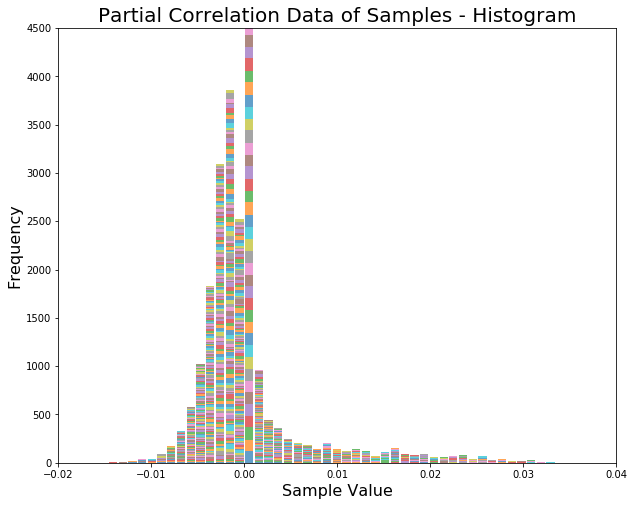

In [13]:
# Initialize plot
fig = plt.figure(figsize=(10,8))

# Histogram
bins = plt.hist(x=parcor_t, bins=50, stacked = True, alpha=0.7, rwidth=0.85)

# Plot best fit
# mu, sigma = norm.fit(parcor_t)
# #sigma = norm.fit(parcor_t)[1]
# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax)
# y = norm.pdf(x, mu, sigma)
# #y = mlab.normpdf(bins, mu, sigma)
# #y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
# plt.plot(x, y, '--', color= 'black')

# Plot lables
plt.xlabel('Sample Value', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Partial Correlation Data of Samples - Histogram', fontsize=20)
#plt.legend(loc = 'right')
plt.xlim(-0.02, 0.04)
plt.ylim(0, 4500)


plt.show()
# maxfreq = bins.max()
# # Set a clean upper y-axis limit.
# plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [14]:
# concatenate all the columns by stacking
concat = parcor_t.stack(dropna = False)
df_concat = concat.reset_index()
df_concat.columns = ['A', 'B', 'Weights']
df_concat

,A,B,Weights
0,OTU_1,OTU_1,0.027323
1,OTU_1,OTU_2,-0.004459
2,OTU_1,OTU_3,-0.012153
3,OTU_1,OTU_5,0.015746
4,OTU_1,OTU_4,-0.010428
5,OTU_1,OTU_239,0.009596
6,OTU_1,OTU_10,0.000659
7,OTU_1,OTU_8,0.003736
8,OTU_1,OTU_7,0.002260
9,OTU_1,OTU_6,-0.002704


In [15]:
# sort the columns in ascending order, by the weights column
df_sort = df_concat.sort_values(by = 'Weights')
df_sort

,A,B,Weights
760,OTU_5,OTU_2,-0.016753
256,OTU_2,OTU_5,-0.016753
268,OTU_2,OTU_24,-0.014554
3796,OTU_24,OTU_2,-0.014554
784,OTU_5,OTU_16,-0.014493
6328,OTU_16,OTU_5,-0.014493
25,OTU_1,OTU_16,-0.013934
6325,OTU_16,OTU_1,-0.013934
20999,OTU_145,OTU_1,-0.013648
83,OTU_1,OTU_145,-0.013648


In [16]:
# store top and bottom 2.5% of values in two lists
# also ascending order
df_len = len(df_sort)
percent = int(df_len * (0.025))
top_percent = df_sort[0:percent]
bottom_percent = df_sort[-percent:]
total_5 = top_percent.append(bottom_percent).dropna()
total_5

,A,B,Weights
760,OTU_5,OTU_2,-0.016753
256,OTU_2,OTU_5,-0.016753
268,OTU_2,OTU_24,-0.014554
3796,OTU_24,OTU_2,-0.014554
784,OTU_5,OTU_16,-0.014493
6328,OTU_16,OTU_5,-0.014493
25,OTU_1,OTU_16,-0.013934
6325,OTU_16,OTU_1,-0.013934
20999,OTU_145,OTU_1,-0.013648
83,OTU_1,OTU_145,-0.013648


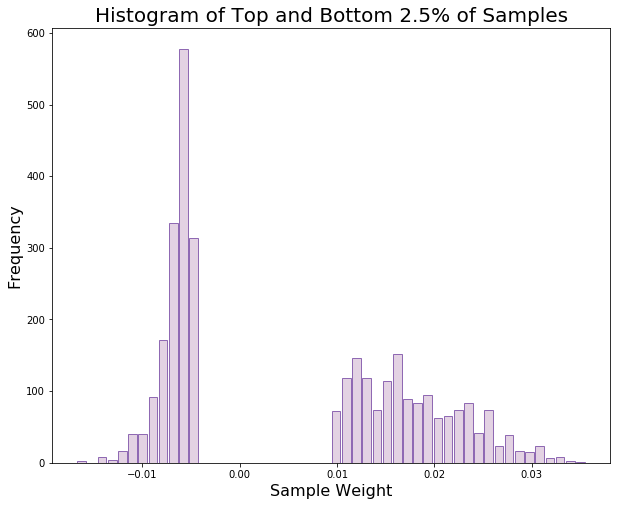

In [17]:
# Initialize plot
fig = plt.figure(figsize=(10,8))

# Histogram
bins = plt.hist(x=total_5['Weights'], bins=50, stacked = True, alpha=0.7, rwidth=0.85, color="thistle", edgecolor="rebeccapurple")

# Plot lables
plt.xlabel('Sample Weight', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Histogram of Top and Bottom 2.5% of Samples', fontsize=20)
#plt.legend(loc = 'right')
#plt.xlim(-0.02, 0.04)
#plt.ylim(0, 4500)


plt.show()

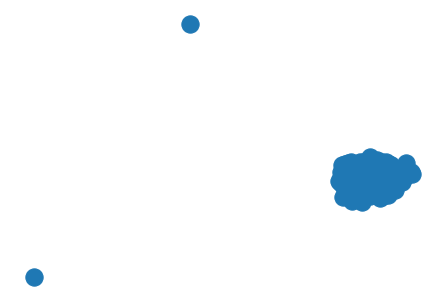

In [18]:
# Build network
g = nx.from_pandas_edgelist(total_5, source='A', target='B', edge_attr=['Weights'])
nx.draw(g)

In [19]:
# Unique lists of A and B columns
source = list(total_5.A.unique())
target = list(total_5.B.unique())

In [20]:
# Dictionary of target values to target values to compare
target_dict = dict(zip(target, target))

# number of connections specified value has coming out of it
g.degree('OTU_2')

78

In [21]:
# Testing values of target in the dictonary
#[target for target in target]

# Number of targets for each target in the dictonary order
#[g.degree(target) for target in target]

In [ ]:
# plt.figure(figsize=(20,20))

# # Create the graph
# g = nx.from_pandas_edgelist(total_5, source='A', target='B', edge_attr=['Weights'])

# # Create a layout for our nodes 
# layout = nx.spring_layout(g, iterations=1, scale=1)

# # Edges thin and grey
# # Source small and grey
# # Targets sized according to their number of connections
# # Targets blue
# # Labels for targets ONLY
# # Sources who are highly connected are a highlighted color

# # Go through every target name, ask the graph how many
# # connections it has. Multiply that by 10 to get the circle size
# target_size = [g.degree(target) * 20 for target in target]
# nx.draw_networkx_nodes(g, layout, nodelist=target, node_size=target_size, node_color='lightblue')

# # Draw source
# nx.draw_networkx_nodes(g, layout, nodelist=source, node_color='indianred', node_size=50)

# # Draw popular sources
# pop_source = [source for source in source if g.degree(source) > 25]
# nx.draw_networkx_nodes(g, layout, nodelist=pop_source, node_color='rebeccapurple', node_size=50)

# nx.draw_networkx_edges(g, layout, width=1, edge_color="lightgray")

# node_labels = dict(zip(target, target))
# nx.draw_networkx_labels(g, layout, labels=node_labels, font_size=12)

# # Turn off the axis 
# plt.axis('off')

# plt.title("Graphical Network")

# # Show graph
# plt.show()# 

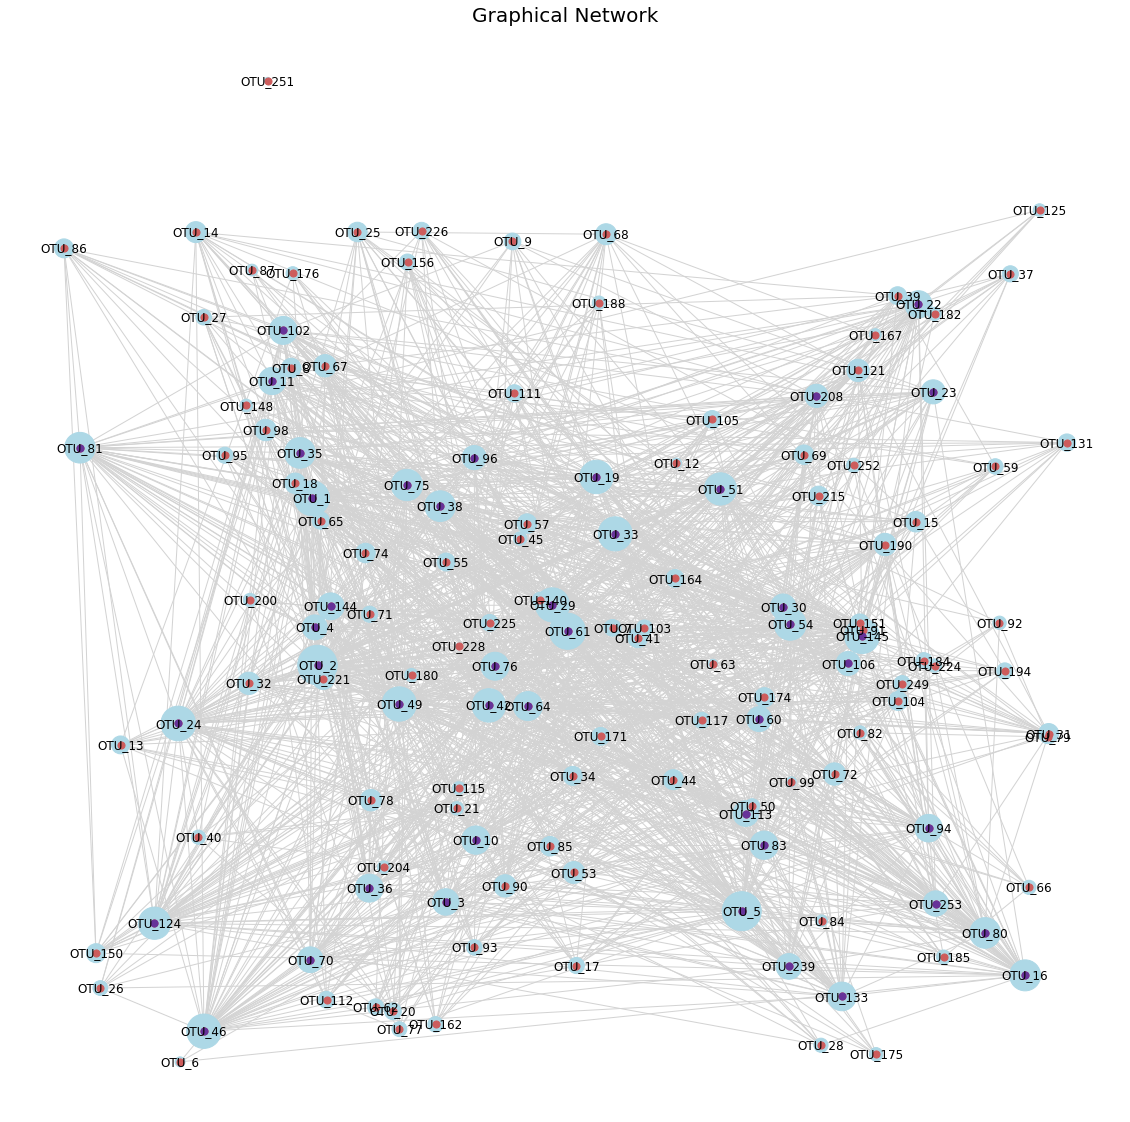

In [27]:
# Create the graph and plot
plt.figure(figsize=(20, 20))
g = nx.from_pandas_edgelist(total_5, source='A', target='B', edge_attr=['Weights'])

# Create a layout for our nodes 
layout = nx.spring_layout(g,iterations=1, scale=1)

# Unique lists of A and B columns
source = list(total_5.A.unique())
target = list(total_5.B.unique())

# Draw the parts
# Edges
nx.draw_networkx_edges(g, layout, edge_color='lightgray')

# Target details
target = [node for node in g.nodes() if node in target]
size = [g.degree(node) * 20 for node in g.nodes() if node in target]
nx.draw_networkx_nodes(g, layout, nodelist=target, node_size=size, node_color='lightblue')

# Source details
source = [node for node in g.nodes() if node in source]
nx.draw_networkx_nodes(g, layout, nodelist=source, node_size=50, node_color='indianred')

# Popular source details
pop_source = [node for node in g.nodes() if node in source and g.degree(node) > 25]
nx.draw_networkx_nodes(g, layout, nodelist=pop_source, node_size=50, node_color='rebeccapurple')

# All source labels
# source_dict = dict(zip(source, source))
# nx.draw_networkx_labels(g, layout, labels=source_dict, font_size=12, color='green')

# All target labels
target_dict = dict(zip(target, target))
nx.draw_networkx_labels(g, layout, labels=target_dict, font_size=12, color='black')

# Turn off axis
plt.axis('off')

plt.title("Graphical Network", fontsize=20)

# Show graph
plt.show()

In [ ]:
#Distributions - standard normal distribution
# negative binomial/boltzmann - have a fxnal form associated wiht them that we know - can use statistical test
# ex: student ttest in standard norm dist to get significant, how likely is the point derived with a diff mean/variance
# most things are anti-correlational - mroe things have diff directions accross samples vs sample
# exp designed for competition for substrate
# more things in competetive/anticorrelated relationship vs positive relationship

#make figure lots nice
#look at most sig relationships based on the dist itself
# take 2.5% of values at both ends - take all values, sort them, and nXn where n is the number of species,
# and take smalled 2.5% and biggest 2.5% - thsoe represent connections in our network - plot final network
# fit fxn - kernel density estimation - tries to do a smooth fit
# take smooth dist and apply same filter
# also cumulative dist
# need to use imperical methos to analyze which is why we don't jsut do a normal dist fit
# use networkx took to make the netowrk graph, or use cytoscape
